In [2]:
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

plt.style.use('fivethirtyeight')
from IPython.core.pylabtools import figsize
# figsize(16, 5)

# 预处理

- data are usually fat-tailed

In [31]:
# !pip install tushare

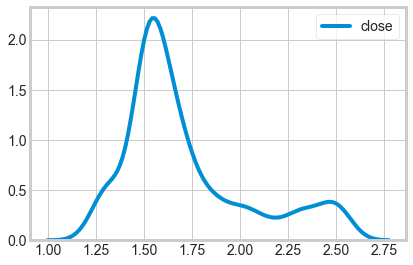

In [48]:
import tushare as ts

# 包钢股份
df = ts.get_hist_data('600010',start='2015-01-05',end='2020-01-09')
sns.kdeplot(df['close'])

- Log transformation

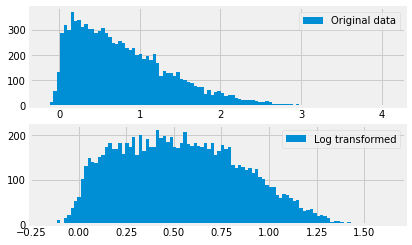

In [8]:
# log transform to mitigate skewness
from scipy.stats import skewnorm

rvs = skewnorm.rvs(20, size=10000)

_, axes = plt.subplots(nrows=2, ncols=1)
_ = axes[0].hist(rvs, bins=100, label='Original data')
axes[0].legend()
_ = axes[1].hist(np.log1p(rvs), bins=100, label='Log transformed')
axes[1].legend()

/Users/liuzhehao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Text(15, 2.2, 'y=log(x)')

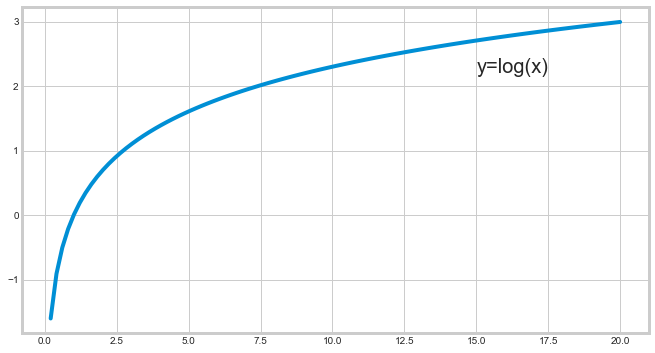

In [22]:
import seaborn as sns
sns.set_style('whitegrid')


x = np.linspace(0, 20, 100)
plt.plot(x, np.log(x))

plt.annotate('y=log(x)', (15, 2.2), size=20)

- Box-Cox transform

In [7]:
def box_cox(x, lambda_=1.0):
    if lambda_ == 0:
        return np.log(x)
    else:
        return (np.power(x, lambda_) - 1) / lambda_

Text(0, 0.5, 'X after transformation')

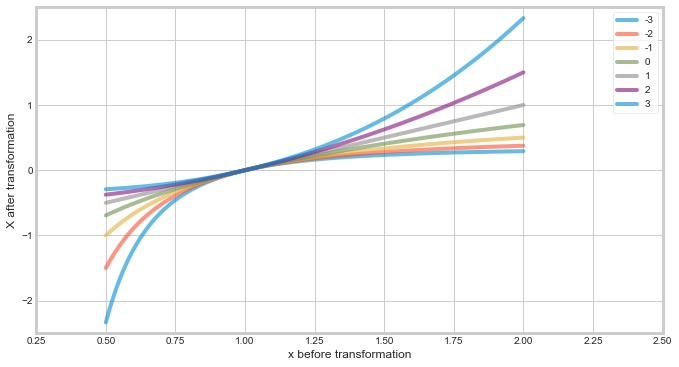

In [8]:
# how does the value of lambda affect the transformations
import seaborn as sns
sns.set_style('whitegrid')

x = np.linspace(0.5, 2, 100)

for l in [-3, -2, -1, 0, 1, 2, 3]:
    plt.plot(x, box_cox(x, l), label=l, alpha=0.6)

plt.legend()
plt.xlim(0.25, 2.5)
plt.ylim(-2.5, 2.5)

plt.xlabel('x before transformation')
plt.ylabel('X after transformation')

- seasonal decomposition

In [52]:
base = np.arange(1000)
seasonal = np.sin(base / 50) * 100 + 100

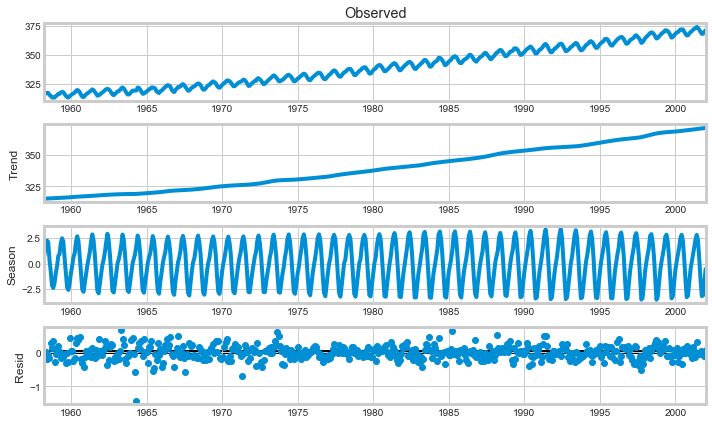

In [24]:
# !pip install statsmodels
from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import STL

figsize(10, 6)

data = co2.load(True).data
data = data.resample('M').mean().ffill()

res = STL(data).fit()
_ = res.plot()


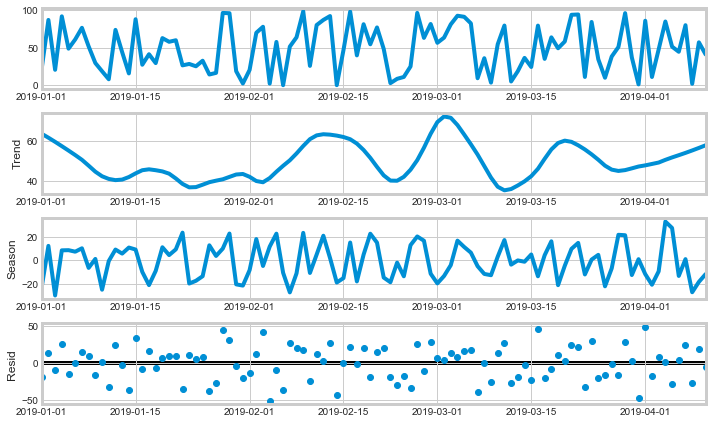

In [40]:
# 没有明显周期性的数据
np.random.seed(5)
data = pd.Series(np.random.random(100)*100, index=pd.date_range('2019-01-01', periods=100))

res = STL(data).fit()
_ = res.plot()

- median filter


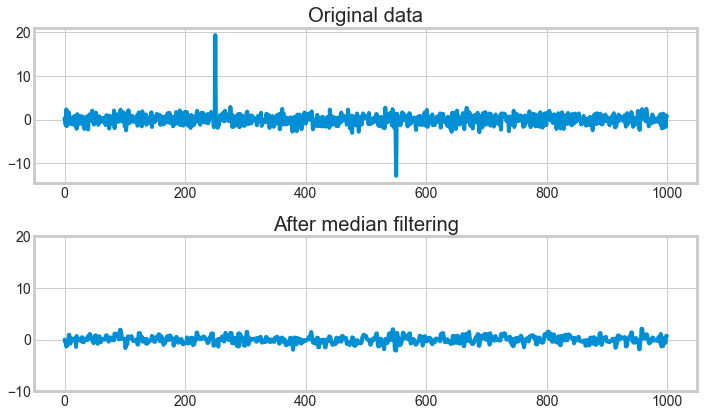

In [260]:
from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import STL

figsize(10, 6)

np.random.seed(124)
data = np.random.randn(1000)

# 手动加入一些毛刺
data[250] += 20
data[550] -= 15

_, axes = plt.subplots(2, 1)

# 使用中值滤波后
from scipy.signal import medfilt

axes[0].plot(data)
axes[0].set_title('Original data')
axes[1].plot(medfilt(data, 3))
axes[1].set_title('After median filtering')
axes[1].set_ylim(-10, 20)

plt.tight_layout()

# 异常检测

### 尖峰&波谷

- grubbs test中critical value随样本量N的变化关系
![critical value formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/c7f608553c276119972bb385dd5e1798cd5476a1)

Text(0.5, 1.0, 'Critical Value vs. Sample Size')

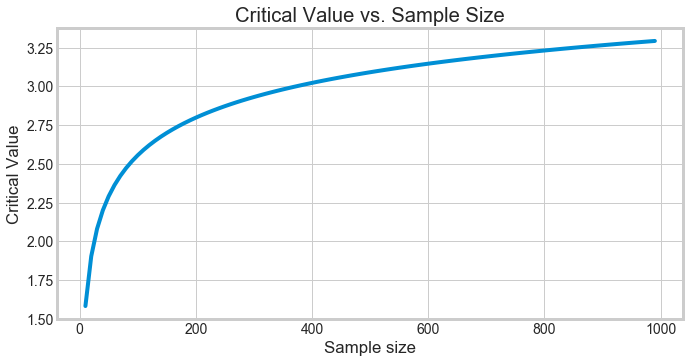

In [148]:
from scipy import stats

figsize(10, 5)

def grubbs_test_critical_value(alpha: float=0.05, N: int=100):
    """ alpha => significance level, N => sample size """
    alpha = max(alpha, 1-alpha)  # upper limit
    
    v = np.square(stats.t.ppf(alpha/(2*N), N-2))
    
    return (N -1) / np.sqrt(N) * np.sqrt(v/(N-2+v))



N = np.arange(10, 1000, 10)
cv = [grubbs_test_critical_value(0.05, n) for n in N]

plt.plot(N, cv)

plt.xlabel('Sample size')
plt.ylabel('Critical Value')

plt.title('Critical Value vs. Sample Size')

- apply ESD test on seasonal data

In [149]:
# artificial dataset
# !pip install PyAstronomy
from PyAstronomy import pyasl

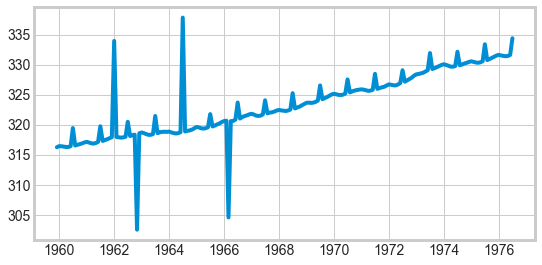

In [161]:
import random

random.seed(100)

figsize(8, 4)

data = co2.load(True).data
data = data.resample('M').mean().ffill()['co2']

# 只留6月一个尖峰
data.loc[data.index.month != 6] = np.convolve(data.loc[data.index.month != 6], [1/12] * 12, mode='same')
data = data.iloc[20: 220]

# 加入四个异常点
# peak outlier location [25, 55]
for i in [25, 55]:
    data.iloc[i] *= 1.05
    
# valley outlier location [35, 75]
for i in [35, 75]:
    data.iloc[i] *= 0.95
    

plt.plot(data)

In [156]:
print('不做时序分解检验出的异常点位置：')
print(pyasl.asl.outlier.generalizedESD(data, 4, alpha=0.05)[1])

print('时序分解后检验出的异常点位置：')
print(pyasl.asl.outlier.generalizedESD(STL(data).fit().resid, 4, alpha=0.05)[1])

不做时序分解检验出的异常点位置：
[35, 75]
时序分解后检验出的异常点位置：
[25, 35, 55, 75]


### 均值变化

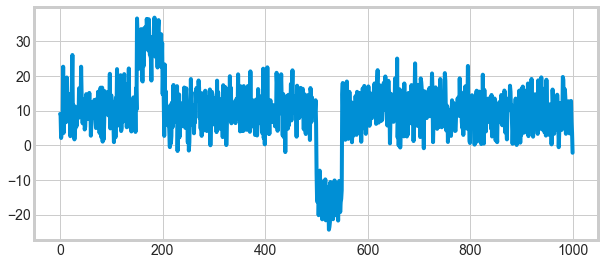

In [323]:
np.random.seed(512)

figsize(9, 4)

data = np.random.randn(1000) * 5 + 10

data[150: 200] += 20
data[500: 550] -= 25

plt.plot(data)

                                                                
t:   2%|▏         | 1/50 [71:38:28<3510:25:31, 257908.80s/it, now=None]

t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]

MoviePy - Building file ./ttest.gif with imageio.
0.0 7.240377076134421e-58




t:  17%|█▋        | 2/12 [00:00<00:01,  5.82it/s, now=None]

t:  25%|██▌       | 3/12 [00:00<00:01,  5.08it/s, now=None]

1.0 0.07312872151977737




t:  33%|███▎      | 4/12 [00:00<00:01,  5.49it/s, now=None]

2.0 0.8473122946471464
3.0 0.3463766129019694




t:  42%|████▏     | 5/12 [00:00<00:01,  5.59it/s, now=None]

t:  50%|█████     | 6/12 [00:01<00:01,  5.63it/s, now=None]

4.0 0.5725449092121069
5.0 0.8880333539689991




t:  58%|█████▊    | 7/12 [00:01<00:00,  5.56it/s, now=None]

t:  67%|██████▋   | 8/12 [00:01<00:00,  5.86it/s, now=None]

6.0 0.112553727395008
7.0 4.7959424364474264e-85




t:  75%|███████▌  | 9/12 [00:01<00:00,  6.29it/s, now=None]

t:  83%|████████▎ | 10/12 [00:01<00:00,  6.55it/s, now=None]

8.0 0.15150300728295063
9.0 0.050412121482965616




t:  92%|█████████▏| 11/12 [00:01<00:00,  6.64it/s, now=None]

t: 100%|██████████| 12/12 [00:01<00:00,  6.72it/s, now=None]

10.0 0.7981343261737737
11.0 0.42913574144202005


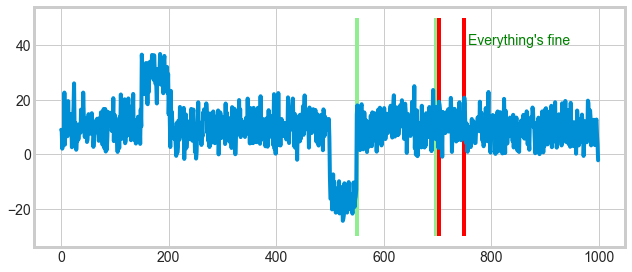

In [324]:
# 检测演示
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


# 检测参数
observe_window_length = 150
detection_window_length = 50
significance_level = 0.01


fig, ax = plt.subplots()

data_ = data.copy()

def make_frame(t):
    
    # 跳过第一桢
    if isinstance(t, int) and t == 0:
        return mplfig_to_npimage(fig)
    
    ax.clear()
    
    observe_window_length = 150
    detection_window_length = 50
    significance_level = 0.05

    detection_start = int(t) * detection_window_length+observe_window_length
    observe_start = detection_start-observe_window_length

    observe_period = data_[observe_start: detection_start]
    detect_period = data_[detection_start: detection_start+detection_window_length]

    # 对已经检测出的异常值置为空，并在检测时候忽略
    ttest_p_value = ttest_ind(observe_period, detect_period, nan_policy='omit').pvalue

    ax.plot(data)

    plt.vlines(observe_start, -30, 50, color='lightgreen')
    plt.vlines(detection_start-1, -30, 50, color='lightgreen')
    plt.vlines(detection_start-3, -30, 50, color='lightgreen')
    plt.vlines(detection_start+3, -30, 50, color='red')
    plt.vlines(detection_start+detection_window_length, -30, 50, color='red')
    
    print(t, ttest_p_value)
    if  ttest_p_value < significance_level:
        text = 'Anomaly alert!!'.format(ttest_p_value)
        plt.annotate(text, (detection_start+detection_window_length+6, 40), color='red')  

        data_[detection_start: detection_start+detection_window_length] = np.nan
        plt.tight_layout()
    else:
        text = "Everything's fine"
        plt.annotate(text, (detection_start+detection_window_length+6, 40), color='green')    
        plt.tight_layout()
    
    return mplfig_to_npimage(fig)


animation = VideoClip(make_frame, duration=12)
animation.write_gif('./ttest.gif', fps=1)

### 方差变化

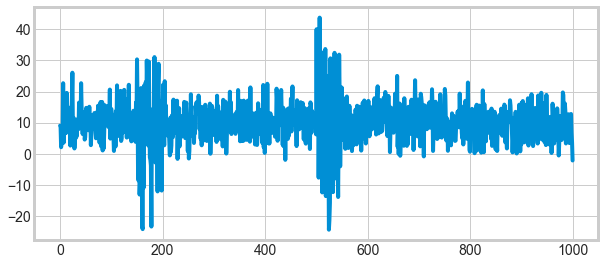

In [328]:
np.random.seed(512)

figsize(9, 4)

data = np.random.randn(1000) * 5 + 10

def increase_variance(s, scale=3):
    med = np.median(s)
    res = s - med
    
    return med + scale * res
    
    
data[150: 200] = increase_variance(data[150: 200], scale=3)
data[500: 550] = increase_variance(data[500: 550], scale=4)

plt.plot(data)

In [334]:
from scipy import stats

def f_test(a, b, significance_level=0.05):
    # degree of freedom
    df_a, df_b = len(a) - 1, len(b) - 1
    
    F = np.var(a) / np.var(b)
    p_value = stats.f.cdf(F, df_a, df_b)
    
    # two tail
    significance_level = min(significance_level, 1-significance_level)
    return p_value < significance_level or p_value > 1-significance_level
        

                                                                       
t:   2%|▏         | 1/50 [71:48:46<3518:49:38, 258526.09s/it, now=None]

t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]

t:  17%|█▋        | 2/12 [00:00<00:00, 11.73it/s, now=None]

MoviePy - Building file ./ftest.gif with imageio.




t:  25%|██▌       | 3/12 [00:00<00:00,  9.40it/s, now=None]

t:  33%|███▎      | 4/12 [00:00<00:00,  8.50it/s, now=None]

t:  42%|████▏     | 5/12 [00:00<00:00,  7.89it/s, now=None]

t:  50%|█████     | 6/12 [00:00<00:00,  7.18it/s, now=None]

t:  58%|█████▊    | 7/12 [00:00<00:00,  6.92it/s, now=None]

t:  67%|██████▋   | 8/12 [00:01<00:00,  6.65it/s, now=None]

t:  75%|███████▌  | 9/12 [00:01<00:00,  7.00it/s, now=None]

t:  83%|████████▎ | 10/12 [00:01<00:00,  7.19it/s, now=None]

t:  92%|█████████▏| 11/12 [00:01<00:00,  7.29it/s, now=None]

t: 100%|██████████| 12/12 [00:01<00:00,  7.52it/s, now=None]

                                                            

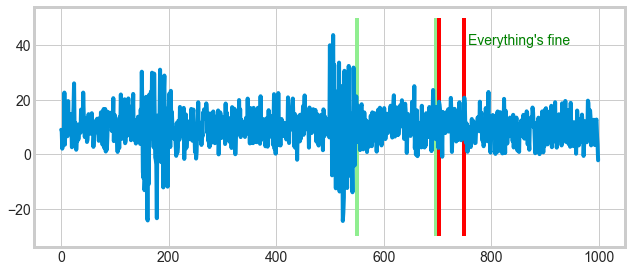

In [338]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


# 检测参数
observe_window_length = 150
detection_window_length = 50
significance_level = 0.01


fig, ax = plt.subplots()

data_ = data.copy()

def make_frame(t):
    
    # 跳过第一桢
    if isinstance(t, int) and t == 0:
        return mplfig_to_npimage(fig)
    
    ax.clear()
    
    observe_window_length = 150
    detection_window_length = 50
    significance_level = 0.05

    detection_start = int(t) * detection_window_length+observe_window_length
    observe_start = detection_start-observe_window_length

    observe_period = data_[observe_start: detection_start]
    detect_period = data_[detection_start: detection_start+detection_window_length]

    # 对已经检测出的异常值置为空，并在检测时候忽略
    is_anomaly = f_test(observe_period, detect_period, significance_level)

    ax.plot(data)

    plt.vlines(observe_start, -30, 50, color='lightgreen')
    plt.vlines(detection_start-1, -30, 50, color='lightgreen')
    plt.vlines(detection_start-3, -30, 50, color='lightgreen')
    plt.vlines(detection_start+3, -30, 50, color='red')
    plt.vlines(detection_start+detection_window_length, -30, 50, color='red')
    
    if  is_anomaly:
        text = 'Anomaly alert!!'.format(ttest_p_value)
        plt.annotate(text, (detection_start+detection_window_length+6, 40), color='red')  

        data_[detection_start: detection_start+detection_window_length] = np.nan
        plt.tight_layout()
    else:
        text = "Everything's fine"
        plt.annotate(text, (detection_start+detection_window_length+6, 40), color='green')    
        plt.tight_layout()
    
    return mplfig_to_npimage(fig)


animation = VideoClip(make_frame, duration=12)
animation.write_gif('./ftest.gif', fps=1)

### 长期趋势
[Mann Kendall Test](https://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm)

In [276]:
def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1
    
    
def calc_s(series):
    S = 0
    for i in range(1, len(series)):
        for j in range(i):
            S += sign(series[i] - series[j])
    return S


variance formula: \begin{equation} \text{VAR}(S) = \frac{1}{18}\Big[n(n-1)(2n+5) 
 - \displaystyle\sum_{p-1}^{g}t_p(t_p-1)(2t_p+5)\Big] \end{equation}
 
where g is the number of tied groups and tp is the number of observations in the p th group. For example, in the sequence of measurements in time {23, 24, 29, 6, 29, 24, 24, 29, 23} we have g = 3 tied groups, for which t1 = 2 for the tied value 23, t2 = 3 for the tied value 24, and t3 = 3 for the tied value 29. When there are ties in the data due to equal values or non-detects, VAR(S) is adjusted by a tie correction method described in Helsel (2005, p. 191) .

In [359]:
from collections import Counter
from scipy.stats import norm

def calc_var(series):
    n = len(series)
    
    base = n * (n - 1) * (2 * n + 5)
    
    adjustment = 0
    for _, tp in Counter(series).items():
        if tp > 1:
            adjustment += tp * (tp - 1) * (2 * tp + 5)
    
    return (base - adjustment) / 18


def mann_kendall_test(series, alpha=0.05):
    """ Two tail mann kendall test """
    alpha = max(alpha, 1-alpha)
    
    S, std = calc_s(series), np.sqrt(calc_var(series))
    
    if S > 0:
        z = (S - 1) / std
    elif S < 0:
        z = (S + 1) / std
    else:
        z = 0
    
    return abs(z) > norm.ppf(alpha)

True

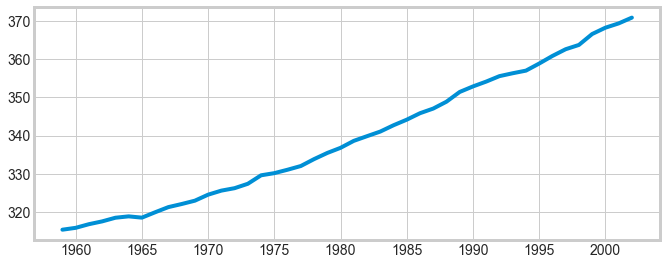

In [364]:
from statsmodels.datasets import co2

figsize(10, 4)

data = co2.load(True).data
data = data.resample('Y').mean().ffill()['co2']

plt.plot(data)
# plt.title('co2')

mann_kendall_test(data.values)